In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
import glob, sys
from decimal import Decimal
from eofs.xarray import Eof
sys.path.append('/home/ysilvy/bin_TS/')
from bin_functions import bin_TS
from eof_functions import compute_eof, proj_on_eof

### Make the ensemble mean from dedrifted data

In [2]:
# -- Read historical members
datadir = '/data/ysilvy/bin_TS/'
V1 = xr.open_dataset(datadir+'volumeTS_dedrifted_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r1i1p1_1850-2100.nc').histogram_so_thetao
V2 = xr.open_dataset(datadir+'volumeTS_dedrifted_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r2i1p1_1850-2100.nc').histogram_so_thetao
V3 = xr.open_dataset(datadir+'volumeTS_dedrifted_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r3i1p1_1850-2100.nc').histogram_so_thetao
V4 = xr.open_dataset(datadir+'volumeTS_dedrifted_global_0.02_0.2_IPSL-CM5A-LR_historical-rcp85_r4i1p1_1850-2100.nc').histogram_so_thetao

In [8]:
# -- Compute ensemble mean
Vmean = (V1+V2+V3+V4)/4

In [12]:
# -- Compute anomalies relative to 1960-2017 and keep only data to 2017 (same as EN4)
Vmean_ano = Vmean.sel(time=slice(1850,2017)) - Vmean.sel(time=slice(1960,2017)).mean(dim='time')

### Fingerprint  = leading EOF

In [14]:
# -- Perform EOF 
solver=Eof(Vmean_ano.stack(z=('so_bin','thetao_bin')))
pcs = solver.pcs()
eofs = solver.eofs()
var1 = solver.varianceFraction()[0].data*100
eof1 = eofs[0,:].unstack('z')

### Project historical field onto the fingerprint

In [15]:
V1_ano = V1.sel(time=slice(1960,2017)) - V1.sel(time=slice(1960,2017)).mean(dim='time')
V2_ano = V2.sel(time=slice(1960,2017)) - V2.sel(time=slice(1960,2017)).mean(dim='time')
V3_ano = V3.sel(time=slice(1960,2017)) - V3.sel(time=slice(1960,2017)).mean(dim='time')
V4_ano = V4.sel(time=slice(1960,2017)) - V4.sel(time=slice(1960,2017)).mean(dim='time')
Z1 = solver.projectField(V1_ano.stack(z=('so_bin', 'thetao_bin')),neofs=1)
Z2 = solver.projectField(V2_ano.stack(z=('so_bin', 'thetao_bin')),neofs=1)
Z3 = solver.projectField(V3_ano.stack(z=('so_bin', 'thetao_bin')),neofs=1)
Z4 = solver.projectField(V4_ano.stack(z=('so_bin', 'thetao_bin')),neofs=1)

### Project EN4 

In [19]:
# -- Read EN4
VEN4 = xr.open_dataset(datadir+'volumeTS_global_0.02_0.2_EN4_1950-2017.nc').histogram_so_thetao
# -- Make anomaly
VEN4_ano = VEN4.sel(time=slice('1960','2017')) - VEN4.sel(time=slice('1960','2017')).mean(dim='time')
# -- Project EN4 on leading EOF
ZEN4 = solver.projectField(VEN4_ano.stack(z=('so_bin', 'thetao_bin')),neofs=1)

### Plot

Text(0.5, 1.0, 'PC1')

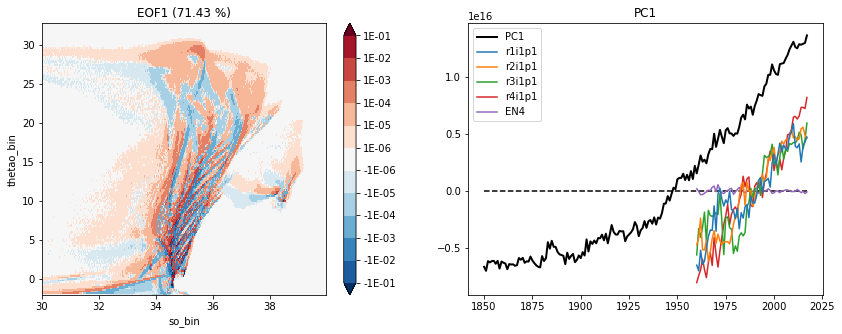

In [26]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(14,5))

time = np.arange(1850,2018)
timeproj = np.arange(1960,2018)

levels = [-1.e-1,-1.e-2,-1.e-3,-1.e-4,-1.e-5,-1.e-6,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2,1.e-1]
levels_str = ['%.0E' % Decimal(str(w)) for w in levels]

c = eof1.T.plot(ax=ax[0],add_colorbar=False,levels=levels,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[0],label='',ticks=levels)
cb.ax.set_yticklabels(levels_str)
ax[0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1))+'%)')
ax[1].plot(time,pcs[:,0],label='PC1',lw=2,color='black',zorder=10)
ax[1].plot(timeproj,Z1,label='r1i1p1',zorder=9)
ax[1].plot(timeproj,Z2,label='r2i1p1',zorder=8)
ax[1].plot(timeproj,Z3,label='r3i1p1',zorder=7)
ax[1].plot(timeproj,Z4,label='r4i1p1',zorder=6)
ax[1].plot(timeproj,ZEN4,label='EN4')
ax[1].legend()
ax[1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1].set_title('PC1')